In [1]:
import numpy as np
rng = np.random.default_rng(seed = 37)

import matplotlib.pyplot as plt
import os

import torch as t
import torchvision as tv
from torchvision.transforms import v2

from tqdm import tqdm

import sys
sys.path.append('utils')

device = t.device("cuda") if t.cuda.is_available() else t.device("cpu")
print(f'Using {device} for inference')

Using cpu for inference


In [2]:
ENV2 = tv.models.efficientnet_v2_s(weights = tv.models.EfficientNet_V2_S_Weights.DEFAULT).to(device)
ENV2.eval();
for param in ENV2.parameters():
    param.requires_grad = False
inference_transform = tv.models.EfficientNet_B0_Weights.IMAGENET1K_V1.transforms()
inference_transforms = v2.Compose([
    lambda x: x.convert('RGB'),
    inference_transform,
])
visualization_transforms = v2.Compose(
    [v2.ToImage(),
     v2.ToDtype(t.float32, scale=True),
     v2.CenterCrop(224),
     ])

In [3]:
fav_pic_index = 28621
data_root = 'imagenet'
imagenet_val_inference = tv.datasets.ImageNet(data_root, split = 'val', transform = visualization_transforms)
fav_image = imagenet_val_inference[fav_pic_index][0]

In [4]:
from distortion import sparse_transform_amplitude, create_grid_sample, find_inv_grid, jacobian_det, get_version

In [8]:
test = []
test.append([1,2,3])

In [10]:
test[0]

[1, 2, 3]

In [7]:
(1, slice(2, 4, None), 3)[1:]

(slice(2, 4, None), 3)

In [5]:
test_class[1,2:4,3]

(1, slice(2, 4, None), 3)


In [44]:
A_nm, B_nm = sparse_transform_amplitude(2, 3, 4, amplitude = 0.6, loop = 2)

In [45]:
grid_sample = create_grid_sample(224, 224, A_nm, B_nm)
grid_sample_2 = create_grid_sample(224, 224, (A_nm[0] + A_nm[1])[None,:,:], (B_nm[0] + B_nm[1])[None,:,:])

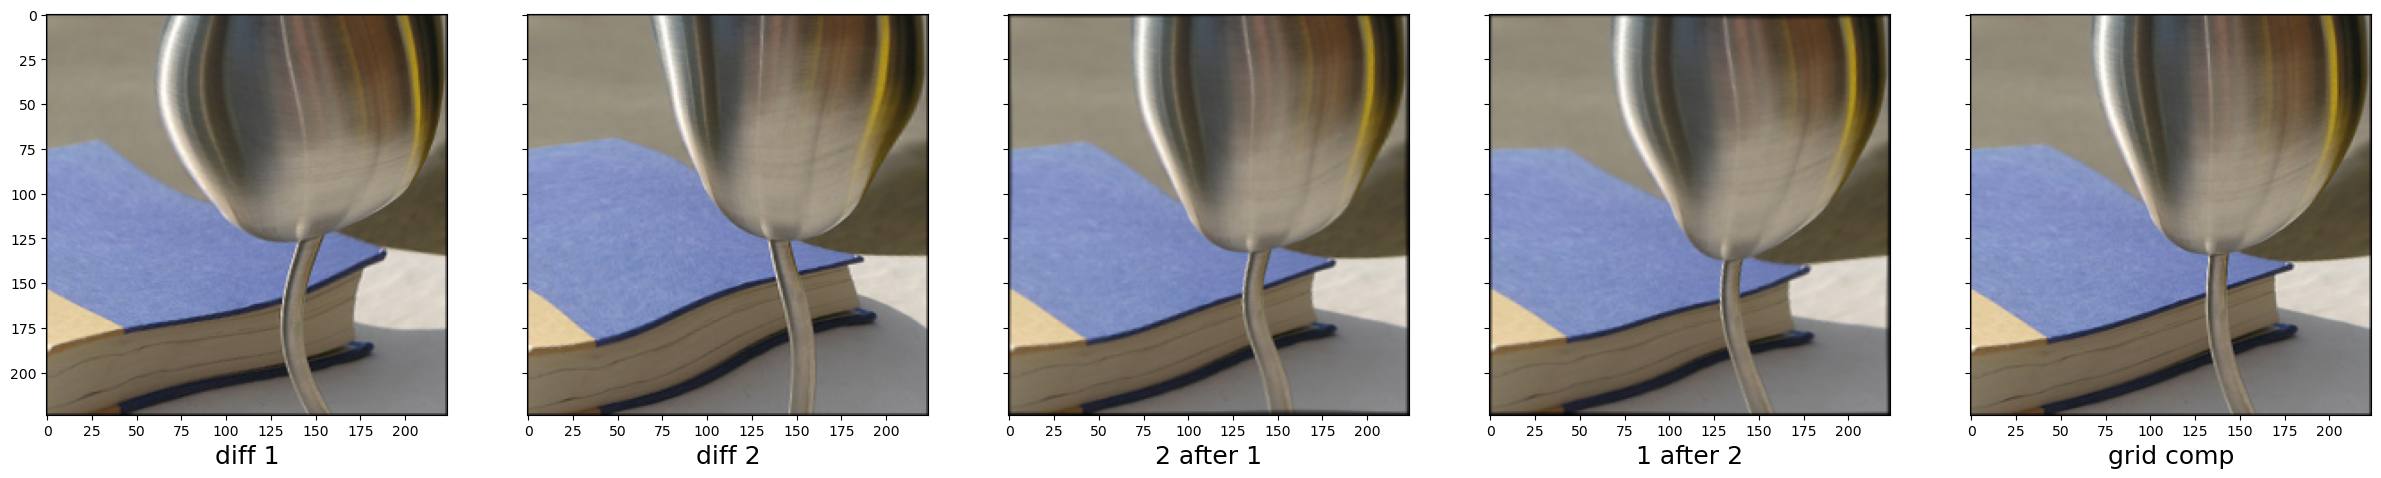

In [46]:
distorted_image = t.nn.functional.grid_sample(fav_image.unsqueeze(0).repeat(2,1,1,1), grid_sample, mode = 'bilinear')
distorted_again = t.nn.functional.grid_sample(distorted_image[0].unsqueeze(0), grid_sample[1].unsqueeze(0), mode = 'bilinear')
distorted_again_2 = t.nn.functional.grid_sample(distorted_image[1].unsqueeze(0), grid_sample[0].unsqueeze(0), mode = 'bilinear')
distorted_doubly = t.nn.functional.grid_sample(fav_image.unsqueeze(0), grid_sample_2, mode = 'bilinear')
fig, axes = plt.subplots(1,5, figsize = (30,6), sharey=True)
axes[0].imshow(v2.ToPILImage()(distorted_image[0].squeeze()));
axes[0].set_xlabel(r'diff 1', fontsize=18);
axes[1].imshow(v2.ToPILImage()(distorted_image[1].squeeze()));
axes[1].set_xlabel(r'diff 2', fontsize=18);
axes[2].imshow(v2.ToPILImage()(distorted_again.squeeze()));
axes[2].set_xlabel('2 after 1', fontsize=18);
axes[3].imshow(v2.ToPILImage()(distorted_again_2.squeeze()));
axes[3].set_xlabel('1 after 2', fontsize=18);
axes[4].imshow(v2.ToPILImage()(distorted_doubly.squeeze()));
axes[4].set_xlabel(r'grid comp', fontsize=18);
# cax = axes[3].matshow(t.linalg.vector_norm((distorted_again - fav_image.unsqueeze(0)).squeeze(), dim = 0));
# axes[3].set_xlabel(r'|A|=1', fontsize=18);
# fig.colorbar(cax)

In [5]:
batch_grid_sample = []
for A, B in zip(A_nm, B_nm):
    grid_sample = create_grid_sample(224, 224, A, B)
    batch_grid_sample.append(grid_sample)
batch_grid_sample = t.cat(batch_grid_sample)

In [6]:
batch_grid_sample.shape

torch.Size([100, 224, 224, 2])

In [15]:
t.allclose(non_batch_grid_sample.squeeze(), batch_grid_sample)

True

In [10]:
def get_sparse_grid_sample(amplitudes, num_diffeo, x_cutoff = 10, y_cutoff = 10, num_terms = 3, x_resolution = 224, y_resolution = 224):
  batch_grid_sample = []
  # batch_inverse_grid_sample = []
  for amp in amplitudes:
    A_nm, B_nm = sparse_transform_amplitude(x_cutoff, y_cutoff, num_terms, amplitude = amp, loop = num_diffeo)
    #A_nm = np.mean(A_nm, axis = 0)
    #B_nm = np.mean(B_nm, axis = 0)
    for A, B in zip(A_nm, B_nm):
      grid_sample = create_grid_sample(x_resolution, y_resolution, A, B)
    #inverse_grid_sample, _ = find_inv_grid(grid_sample)
      batch_grid_sample.append(grid_sample)
    #batch_inverse_grid_sample.append(inverse_grid_sample)
  grid_sample = t.cat(batch_grid_sample)
  return grid_sample

In [13]:
activation = {}
def getActivation(name):
    # the hook signature
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
handles = []

def retrieve_layer_activation(model, input, layer_index):
  if len(input) == 3: input = input[None, :, :, :]

  layers = list(model.children())
  layers_flat = flatten(layers)

  for index in layer_index:
    handles.append(layers_flat[index - 1].register_forward_hook(getActivation(str(index))))

  with t.no_grad(): model(input)
  for handle in handles: handle.remove()

  return

def flatten(array):
    result = []
    for element in array:
        if hasattr(element, "__iter__"):
            result.extend(flatten(element))
        else:
            result.append(element)
    return result

In [11]:
amp_steps = 50
diffeo_num = 50
diffeo_amp = t.linspace(0, 1.5, amp_steps)
grid_sample = get_sparse_grid_sample(diffeo_amp, diffeo_num, x_cutoff= 10, y_cutoff = 10, num_terms = 3, x_resolution =224, y_resolution= 224)

In [12]:
grid_sample.shape

torch.Size([2500, 224, 224, 2])

In [ ]:
#path = '/content/drive/Shareddrives/Diffeomorphisms_&_CNNs/Alex/data/'
#t.save(grid_sample, path + '20-50-10-10-3-224-224_grid_sample.pt')
last_layer_activation = []
imagenet_val_loader = iter(t.utils.data.DataLoader(imagenet_val_inference, batch_size = 1, shuffle=False))
for i in tqdm(range(100)):
  #file_prefix = f'20-50-10-10-3-224-224_image-{i:04d}_activation'
  val_image, _ = next(imagenet_val_loader)
  distorted_list = t.nn.functional.grid_sample(val_image.repeat(amp_steps * diffeo_num,1,1,1), grid_sample, mode = 'bilinear').to(device)
  retrieve_layer_activation(ENV2, distorted_list, [49])
  last_layer_activation.append(activation['49'])
  activation = {}
  handle = []
